In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LogisticRegression # clf model
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_union # combine two vectors
from sklearn.model_selection import cross_val_score # validate clf using training data

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# Load the datasets
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

In [3]:
# Let's check the size of the training data
train_data.shape

(159571, 8)

In [4]:
# Here is how data looks like
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
# check the data distribution across the dataset
value_counts = train_data.iloc[:,2:].apply(pd.Series.value_counts)
print(value_counts.iloc[1])


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
Name: 1, dtype: int64


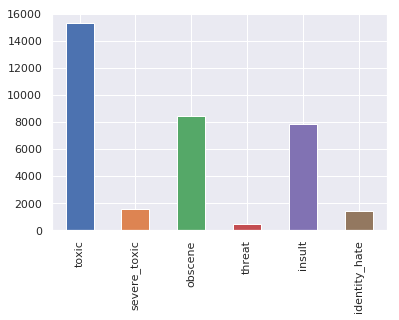

In [27]:
# see a bar chart for this counts
value_counts.iloc[1].plot(kind='bar')

In [ ]:
## Text Processing
# Create word and char Tfidf vectors

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)


In [ ]:
# combine the word and char vectors
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=3)

In [ ]:
# convert comments to vectors (bag of words)

train_comments = train_data['comment_text']
test_comments = test_data['comment_text']

vectorizer.fit(train_comments)

train_features = vectorizer.transform(train_comments)
test_features = vectorizer.transform(test_comments)

In [ ]:
scores = []
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
submission = pd.DataFrame.from_dict({'id': test_data['id']})

# Train each class, validate using cross validate and predic the probability
for class_name in class_names:
    train_target = train_data[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

# Result to csv file for submission
submission.to_csv('submission.csv', index=False)